In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mabu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## 1. Load the dataset

We will be using the IMDB dataset of 50K Movie reviews. The goal is to train a LSTM model to predict the sentiment. There are two possible values: 'positive’ and ‘negative’. Hence this is a binary classification task.

In [6]:
file_name = 'NEU/IMDB Dataset.csv'
df = pd.read_csv(file_name)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 2. Exploratory data analysis

train data shape: (37500,)
test data shape: (12500,)


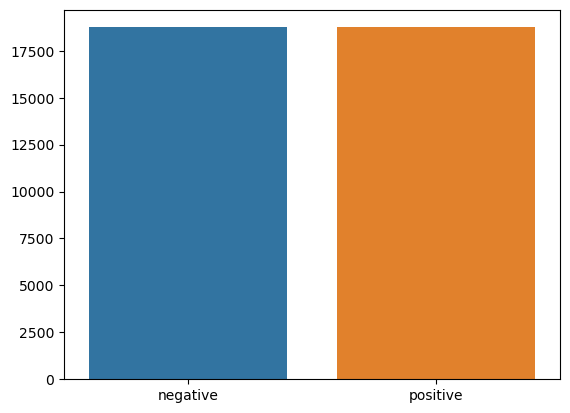

In [7]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'train data shape: {x_train.shape}')
print(f'test data shape: {x_test.shape}')


dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

## 3. Text preprocessing

Text preprocessing and tokenization is a critical first step. First, we clean up the text data by removing punctuation, extra spaces, and numbers.

We then transform sentences into individual words, remove common words (known as "stop words"), and keep track of the 1000 most frequently used words in the dataset. These words are then assigned a unique identifier, forming a dictionary for one-hot encoding.

The code essentially is converting the original text sentences into sequences of these unique identifiers, translating human language into a format that a machine learning model can understand.

In [8]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s


def tokenize(x_train,y_train,x_val,y_val):
    word_list = []


    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
 
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
   
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])
           
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)


/tmp/ipykernel_241/2803977465.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


Let’s analyze the token length in x_train.

<AxesSubplot: >

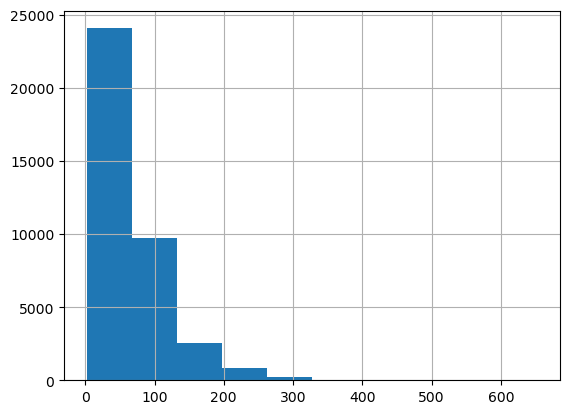

In [9]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()

## 4. Preparing the data for the model

Given the variable token lengths of each review, it's necessary to standardize them for consistency. As the majority of reviews contain less than 500 tokens, we'll establish 500 as the fixed length for all reviews.

In [10]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

Next, we use DataLoader class to create the final dataset for model training.

In [11]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))


# dataloaders
batch_size = 50


# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)


# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)


print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 275, 816,   1],
        [  0,   0,   0,  ..., 316, 682,  97],
        [  0,   0,   0,  ...,  77, 251,  25],
        ...,
        [  0,   0,   0,  ..., 486, 376,  38],
        [  0,   0,   0,  ..., 476, 239,  32],
        [  0,   0,   0,  ...,  58, 925,   1]])
Sample output: 
 tensor([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1])


## 5. Define the LSTM model

This part of the code defines a sentiment analysis model using a recurrent neural network (RNN) architecture, specifically a type of RNN called Long Short-Term Memory (LSTM). The SentimentRNN class is a PyTorch model that starts with an embedding layer, which transforms word indices into a dense representation that captures the semantic meaning of words. This is followed by an LSTM layer that processes the sequence of word embeddings.

The LSTM's hidden state is passed through a dropout layer (for regularizing the model and preventing overfitting) and a fully connected layer, which maps the LSTM outputs to the final prediction. The prediction is then passed through a sigmoid activation function, converting raw output values into probabilities. The forward method defines the forward pass of data through this network, and the init_hidden method initializes the hidden states of the LSTM layer to zeros.

In [12]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
   
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
       
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
       
        # dropout layer
        self.dropout = nn.Dropout(0.3)
   
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
       
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
       
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
       
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
       
        # sigmoid function
        sig_out = self.sig(out)
       
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)


        sig_out = sig_out[:, -1] # get last batch of labels
       
        # return last sigmoid output and hidden state
        return sig_out, hidden
       
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden 

In [14]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)


#moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


The final step before starting the training process is to define loss and optimization functions. This part focuses on defining the loss function, optimization method, and a utility function for accuracy calculation for our sentiment analysis model.

The loss function used is Binary Cross-Entropy Loss (nn.BCELoss), which is commonly used for binary classification tasks like this one. The optimization method is Adam (torch.optim.Adam), a popular choice due to its efficiency and low memory requirements. The learning rate for Adam is set to 0.001.

The acc function is a helper function designed to calculate the accuracy of our model's predictions. It rounds off the predicted probabilities to the nearest integer (0 or 1), compares these predictions to the actual labels, and then calculates the percentage of correct predictions.

In [15]:
# loss and optimization functions


lr=0.001


criterion = nn.BCELoss()


optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


## 6. Start training

This is the part of the code where the sentiment analysis model is trained and validated. Each epoch (iteration) involves a training phase and a validation phase. During the training phase, the model learns by adjusting its parameters to minimize the loss.

In the validation phase, the model's performance is evaluated on a separate dataset to ensure it's learning generalized patterns and not just memorizing the training data.

The training loop starts by initializing the hidden states of the LSTM and setting the model to training mode. For each batch of data, the model's predictions are compared to the actual labels to compute the loss, which is then backpropagated to update the model's parameters.

Gradients are clipped to a maximum value to prevent them from getting too large, a common issue in training RNNs and LSTMs.

In the validation loop, the model is set to evaluation mode, and its performance is assessed using the validation data without updating any parameters. For both training and validation phases, the code tracks the loss and accuracy for each epoch.

If the validation loss improves, the current model's parameters are saved, capturing the best model found during training.

Finally, after each epoch, the average loss and accuracy for that epoch are printed out, giving insight into the model's learning progress.

In [16]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]


for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
       
        inputs, labels = inputs.to(device), labels.to(device)  
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
       
        model.zero_grad()
        output,h = model(inputs,h)
       
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
       
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])


            inputs, labels = inputs.to(device), labels.to(device)


            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())


            val_losses.append(val_loss.item())
           
            accuracy = acc(output,labels)
            val_acc += accuracy
           
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.5063302760124206 val_loss : 0.41696311652660367
train_accuracy : 75.304 val_accuracy : 81.904
Validation loss decreased (inf --> 0.416963).  Saving model ...
Epoch 2
train_loss : 0.3790347891052564 val_loss : 0.41888708192110063
train_accuracy : 83.856 val_accuracy : 80.96
Epoch 3
train_loss : 0.3387130151689053 val_loss : 0.36958831059932706
train_accuracy : 85.74933333333334 val_accuracy : 84.84
Validation loss decreased (0.416963 --> 0.369588).  Saving model ...
Epoch 4
train_loss : 0.30735344864924746 val_loss : 0.34020023876428607
train_accuracy : 87.12266666666667 val_accuracy : 85.86399999999999
Validation loss decreased (0.369588 --> 0.340200).  Saving model ...
Epoch 5
train_loss : 0.27833037194609644 val_loss : 0.3413495284020901
train_accuracy : 88.50933333333333 val_accuracy : 85.584


## 7. Model evaluation

This part of the code is generating two plots to visually represent the training and validation accuracy and loss over the course of model training. The first subplot displays a line graph of the training and validation accuracy after each epoch. This plot is useful for observing how well the model is learning and generalizing over time.

The second subplot displays a line graph of the training and validation loss. This helps us see whether our model is overfitting, underfitting, or fitting just right.

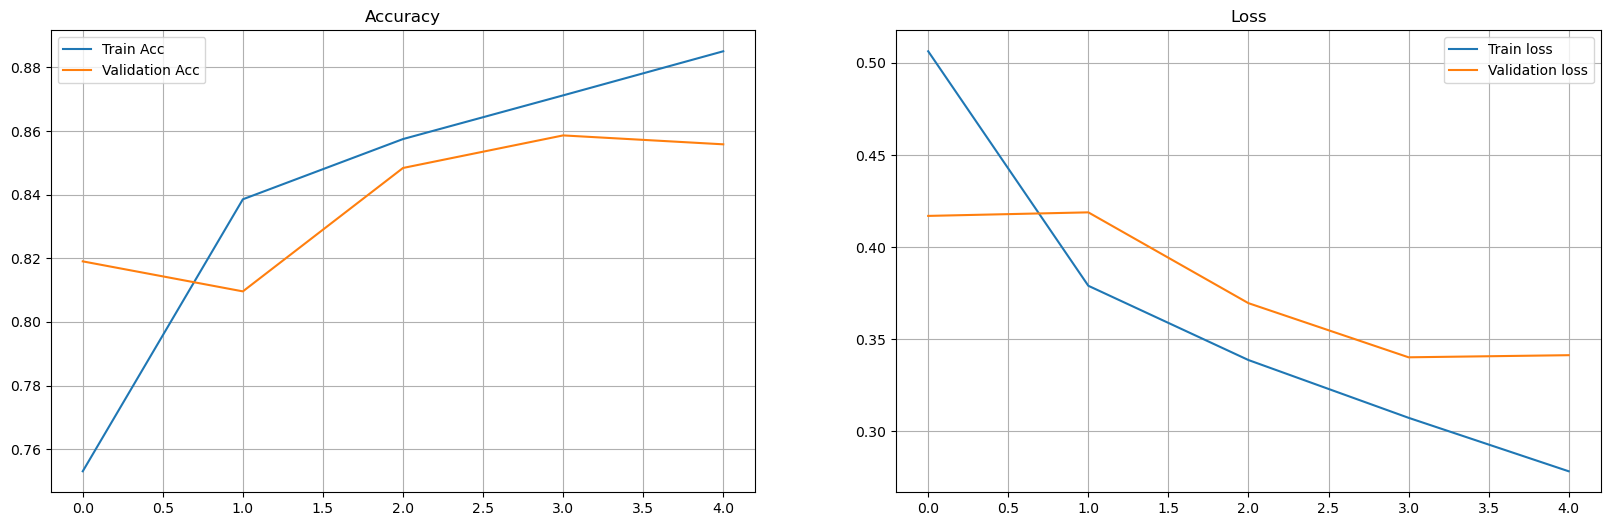

In [17]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
   
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()


plt.show()


## 8. Inference / Prediction

In this part, we create a function predict_text for predicting the sentiment of a given text, and a demonstration of its use. The predict_text function takes as input a string of text, transforms it into a sequence of word indices (according to a pre-defined vocabulary), and prepares it for input into the model by padding and reshaping. The function then initializes the hidden states of the LSTM, feeds the input into the model, and returns the model's output probability of the raw text.

In [18]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())


index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')


Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve